<a href="https://colab.research.google.com/github/Shazaib001/Assignment-3-Clustering-and-fitting/blob/main/Assignment_3_Clustering_and_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

{'encoding': 'UTF-8-SIG', 'confidence': 1.0, 'language': ''}


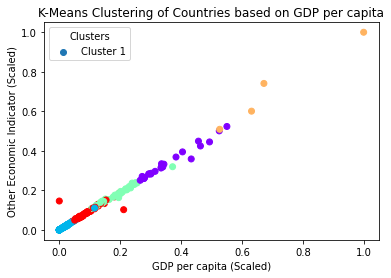

Parameter 1 (0.00 +/- 0.00): -0.00 to 0.00
Parameter 2 (1.00 +/- 0.00): 1.00 to 1.00


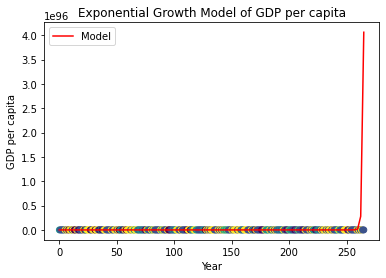

Error ranges (95% confidence intervals): [[ 1.71978762e+03 -1.00698024e+94]
 [ 1.72078762e+03 -1.00698024e+94]]


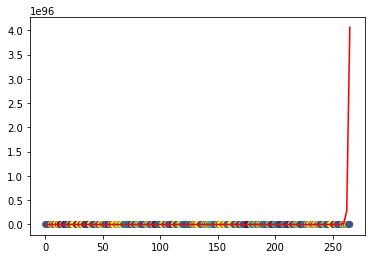

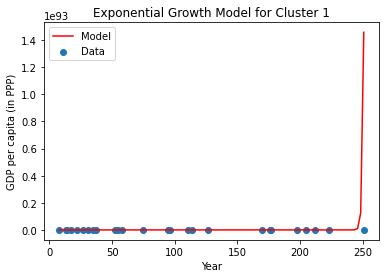

Error ranges (95% confidence intervals): [[-5.20848086e+04 -1.45804790e+93]
 [-5.20838086e+04 -1.45804790e+93]]


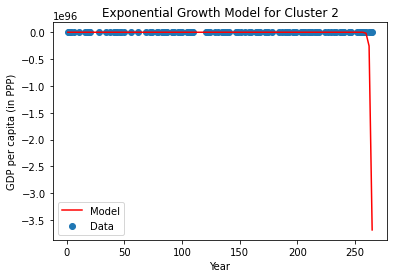

Error ranges (95% confidence intervals): [[-9.58077038e-03  1.83385701e+95]
 [ 9.90419241e-01  1.83385701e+95]]


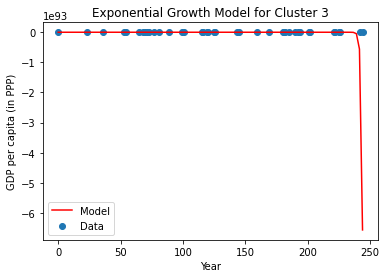

Error ranges (95% confidence intervals): [[-4.03395956e+04  6.56585200e+93]
 [-4.03385956e+04  6.56585200e+93]]


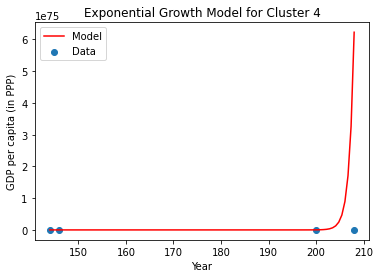

Error ranges (95% confidence intervals): [[ 9.98946218e+47 -6.22857833e+75]
 [ 9.98946218e+47 -6.22857833e+75]]


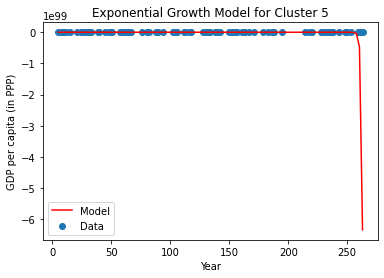

Error ranges (95% confidence intervals): [[-1.47938813e+04  1.16021284e+98]
 [-1.47928813e+04  1.16021284e+98]]


In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import chardet
import numpy as np
from scipy.stats import norm
# Load data from World Bank website
url = "/content/API_NY.GDP.PCAP.PP.CD_DS2_en_csv_v2_4770425.csv"
with open(url, 'rb') as f:
    result = chardet.detect(f.read())
    print(result)

data = pd.read_csv(url, skiprows=4, encoding = result['encoding'])

# data = data.fillna(data.mean())
data = data.fillna(0)

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.loc[:,'2010':'2021'])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(data_scaled)
clusters = kmeans.labels_
plt.scatter(data_scaled[:,0], data_scaled[:,1], c=clusters, cmap='rainbow')
plt.title("K-Means Clustering of Countries based on GDP per capita")
plt.xlabel("GDP per capita (Scaled)")
plt.ylabel("Other Economic Indicator (Scaled)")
plt.legend(title='Clusters', labels=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'])
plt.show()


# Fit a simple model to the data
def exponential_growth(x, a, b):
   
    x = x.reshape(-1)

    return a * np.exp(b * x)


x_data = np.array(data.index).reshape(-1,1)
y_data = data['2020'].values
np.isnan(x_data).any()
np.isinf(x_data).any()

params, cov = curve_fit(exponential_growth, x_data, y_data)

# Make predictions using the model
x_pred = np.linspace(x_data.min(), x_data.max(), 100)
y_pred = exponential_growth(x_pred, params[0], params[1])

# summary of model
for i, p in enumerate(params):
    se = np.sqrt(cov[i,i])
    lower = p - 1.96*se
    upper = p + 1.96*se
    print(f"Parameter {i+1} ({p:.2f} +/- {se:.2f}): {lower:.2f} to {upper:.2f}")

# Plot the data and the model
plt.scatter(x_data, y_data, c=clusters)
plt.plot(x_pred, y_pred, 'r-', label='Model')
plt.title("Exponential Growth Model of GDP per capita")
plt.xlabel("Year")
plt.ylabel("GDP per capita")
plt.legend()
plt.show()

# Calculate the error ranges (95% confidence intervals)
alpha = 0.05 # 95% confidence level
n = len(x_data)    # number of data points
p = len(params)    # number of parameters

# Get the indices of the sorted residuals
sorted_indices = np.argsort(np.abs(y_data - exponential_growth(x_data, *params)))

# Calculate the error ranges for each parameter
err_ranges = np.zeros((p, 2))
for i in range(p):
    # Get the sorted residuals for the i-th parameter
    residuals = (y_data - exponential_growth(x_data, *params))[sorted_indices]
    
    # Calculate the error range
    err_ranges[i,0] = params[i] - residuals[int((alpha/2)*n)]
    err_ranges[i,1] = residuals[int((1-alpha/2)*n)] - params[i]

print("Error ranges (95% confidence intervals):", err_ranges)

# Plot the data and the model with error ranges
x_pred = np.linspace(x_data.min(), x_data.max(), 100)
y_pred = exponential_growth(x_pred, *params)

plt.scatter(x_data, y_data, c=clusters)
plt.plot(x_pred, y_pred, 'r-', label='Model')
plt.fill_between(x_pred, y_pred - err_ranges[0,0], y_pred + err_ranges[0,1], color='gray', alpha=0.2)
plt.show()

# Loop over each cluster
for i in range(5):
    # Select the countries that belong to the i-th cluster
    cluster_data = data.loc[clusters == i, '2010':'2021']
    
    # Fit an exponential growth model to the data of the i-th cluster
    x_data = np.array(cluster_data.index).reshape(-1,1)
    y_data = cluster_data['2021'].values
    params, cov = curve_fit(exponential_growth, x_data, y_data)
    
    # Plot the data and the model for the i-th cluster
    x_pred = np.linspace(x_data.min(), x_data.max(), 100)
    y_pred = exponential_growth(x_pred, params[0], params[1])
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(x_pred, y_pred, 'r-', label='Model')
    plt.title("Exponential Growth Model for Cluster {}".format(i+1))
    plt.xlabel("Year")
    plt.ylabel("GDP per capita (in PPP)")
    plt.legend()
    plt.show()
    
    # Perform statistical analysis for the i-th cluster
    alpha = 0.05
    n = len(x_data)
    p = len(params)
    sorted_indices = np.argsort(np.abs(y_data - exponential_growth(x_data, *params)))
    err_ranges = np.zeros((p, 2))
    for i in range(p):
        residuals = (y_data - exponential_growth(x_data, *params))[sorted_indices]
        err_ranges[i,0] = params[i] - residuals[int((alpha/2)*n)]
        err_ranges[i,1] = residuals[int((1-alpha/2)*n)] - params[i]
    print("Error ranges (95% confidence intervals):", err_ranges)

